# House Prices: Advanced Regression Techniques

Lei Wang@Oct 2020

The task is to have the best possible prediction one can make with the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) on Kaggle.

1. Exploratory Data Analysis
    + Load data
    + Numerical and categorical features
    + Features with missing values
    + Relation of features to target (sale price)
    + Save cleaned data for further analysis


2. Data preprocessing
    + Load cleaned data
    + Numerical features: reducing skewness
    + Categorical features: converting to numerical (option A and B)
    + Merging numerical and categorical data
    + Standardization train and test data
    + Save preprocessed data for further analysis


3. Model evaluation
    + Load preprocessed data
    + Modeling (linear and nonlinear models)
    + Comparison amongst models
    + Correlation of model predictions
    + Sequential Forward Selection (SFS) model stacking
    + Final evaluation
______________________________

This notebook covers section 2. Data preprocessing.

## 2. Data preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import Categorical2Numerical, standardization_train_test
from sklearn import preprocessing
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

%matplotlib inline
sns.set_style("whitegrid")

### 2.1 Load cleaned data

In [2]:
df_train = pd.read_csv("./data/train2.csv")
df_test  = pd.read_csv("./data/test2.csv")

df_train.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)

print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [3]:
#%% split numerical and categorical columns
df_train_num = df_train[[c for c in df_train.columns if df_train[c].dtypes!= "object"]].copy()
df_test_num = df_test[[c for c in df_test.columns if df_test[c].dtypes!= "object"]].copy()

df_train_cat = df_train[[c for c in df_train.columns if df_train[c].dtypes=="object"]].copy()
df_test_cat = df_test[[c for c in df_test.columns if df_test[c].dtypes=="object"]].copy()

In [4]:
df_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [5]:
df_train_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


### 2.2 Numerical features
#### 2.2.1 Reducing skewness (Mapping to a Gaussian distribution)


Skewness is a measure of the symmetry in a distribution. A symmetrical dataset will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. Skewness essentially measures the relative size of the two tails. As a rule of thumb, skewness should be between -1 and 1. In this range, data are considered fairly symmetrical.

In [6]:
# show the Skewness of numerical predictors before and after log(1+x)
numerical_feats_tr = [] # feats with (after log) skew < 1
for col in df_train_num.columns :
    if abs(df_train_num[col].skew()) > 1 : 
        skew_afterlog1p = np.log1p(df_train_num[col]).skew()
        if abs(skew_afterlog1p) < 1:
            numerical_feats_tr.append(col)
        print('{:15}'.format(col), 
              'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
              '   ' ,
              'Skewness after log: {:05.2f}'.format(skew_afterlog1p)  
             )
print('\n')        
print('The following numerical predictors can be reduced with skewness (<1) by using log(1+x):')        
numerical_feats_tr      

MSSubClass      Skewness: 01.41     Skewness after log: 00.25
LotFrontage     Skewness: 02.38     Skewness after log: -0.89
LotArea         Skewness: 12.21     Skewness after log: -0.14
MasVnrArea      Skewness: 02.68     Skewness after log: 00.48
BsmtFinSF1      Skewness: 01.69     Skewness after log: -0.62
BsmtFinSF2      Skewness: 04.26     Skewness after log: 02.52
TotalBsmtSF     Skewness: 01.52     Skewness after log: -5.15
1stFlrSF        Skewness: 01.38     Skewness after log: 00.08
LowQualFinSF    Skewness: 09.01     Skewness after log: 07.46
GrLivArea       Skewness: 01.37     Skewness after log: -0.01
BsmtHalfBath    Skewness: 04.10     Skewness after log: 03.93
KitchenAbvGr    Skewness: 04.49     Skewness after log: 03.87
WoodDeckSF      Skewness: 01.54     Skewness after log: 00.15
OpenPorchSF     Skewness: 02.36     Skewness after log: -0.02
EnclosedPorch   Skewness: 03.09     Skewness after log: 02.11
3SsnPorch       Skewness: 10.30     Skewness after log: 07.73
ScreenPo

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 '1stFlrSF',
 'GrLivArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

In [7]:
# plot before and after log1p
def show_distr(df, List_numerical_feats):
    N = len(List_numerical_feats)
    for i, feat in enumerate(List_numerical_feats):
        plt.figure(figsize=(8,2))
        plt.subplot(1, 2, 1)
        sns.distplot(df[feat])
        plt.title('Original')
        plt.subplot(1, 2, 2)
        newfeat = np.log1p(df[feat])
        #newfeat = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
        sns.distplot(newfeat) 
        plt.tight_layout()
        plt.title('Log transformed')   
        

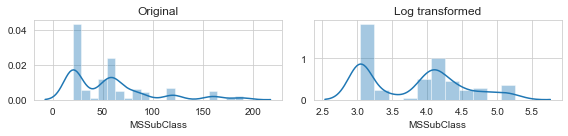

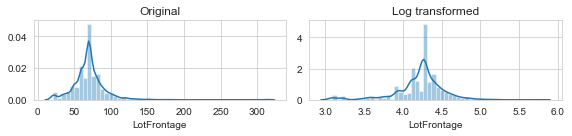

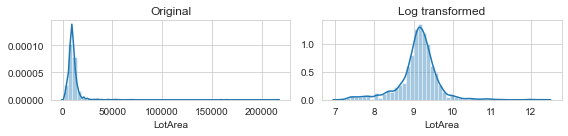

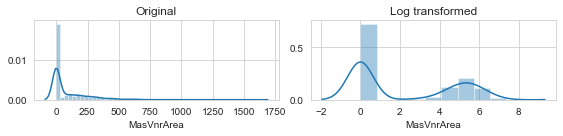

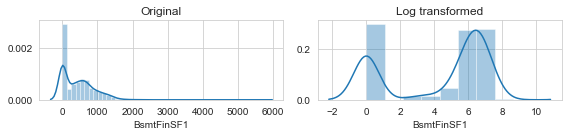

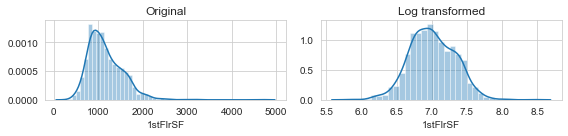

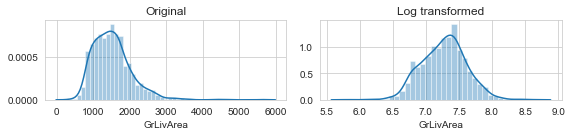

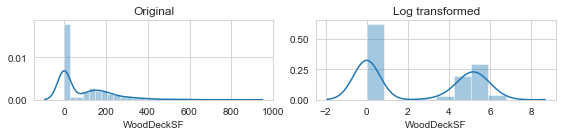

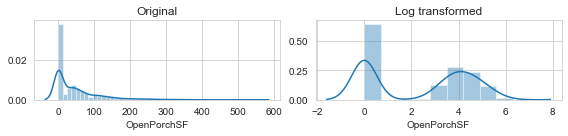

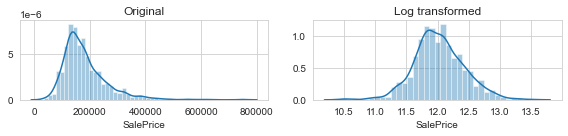

In [8]:
show_distr(df_train, numerical_feats_tr)

Normalizing of the numerical predictors for both train and test sets.

In [9]:
# drop 'SalePrice' to keep 'df_train = df_test'
SalePrice_Log = np.log(df_train_num['SalePrice'])
df_train_num.drop('SalePrice', inplace= True, axis = 1)

# normalizing of the numerical predictors for both train and test sets, 
numerical_feats_tr.remove('SalePrice')
for feat in numerical_feats_tr:   
    for df in [df_train_num, df_test_num]:
        # changing their name by adding '_Log'
        df[(feat+'_Log')] = np.log1p(df[feat])
        df.drop(feat, inplace= True, axis = 1)
        

In [10]:
# check normalized Numerical predictors (name with '_Log')
df_train_num.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,...,YrSold,MSSubClass_Log,LotFrontage_Log,LotArea_Log,MasVnrArea_Log,BsmtFinSF1_Log,1stFlrSF_Log,GrLivArea_Log,WoodDeckSF_Log,OpenPorchSF_Log
0,7,5,2003,2003,0,150,856,854,0,1,...,2008,4.110874,4.189655,9.042040,5.283204,6.561031,6.753438,7.444833,0.000000,4.127134
1,6,8,1976,1976,0,284,1262,0,0,0,...,2007,3.044522,4.394449,9.169623,0.000000,6.886532,7.141245,7.141245,5.700444,0.000000
2,7,5,2001,2002,0,434,920,866,0,1,...,2008,4.110874,4.234107,9.328212,5.093750,6.188264,6.825460,7.488294,0.000000,3.761200
3,7,5,1915,1970,0,540,756,756,0,1,...,2006,4.262680,4.110874,9.164401,0.000000,5.379897,6.869014,7.448916,0.000000,3.583519
4,8,5,2000,2000,0,490,1145,1053,0,1,...,2008,4.110874,4.442651,9.565284,5.860786,6.486161,7.044033,7.695758,5.262690,4.442651


In [11]:
# check normalized Numerical predictors (name with '_Log')
df_test_num.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,...,YrSold,MSSubClass_Log,LotFrontage_Log,LotArea_Log,MasVnrArea_Log,BsmtFinSF1_Log,1stFlrSF_Log,GrLivArea_Log,WoodDeckSF_Log,OpenPorchSF_Log
0,5,6,1961,1961,144.0,270.0,882.0,0,0,0.0,...,2010,3.044522,4.394449,9.360741,0.000000,6.150603,6.799056,6.799056,4.948760,0.000000
1,6,6,1958,1958,0.0,406.0,1329.0,0,0,0.0,...,2010,3.044522,4.406719,9.565775,4.691348,6.828712,7.192934,7.192934,5.976351,3.610918
2,5,5,1997,1998,0.0,137.0,928.0,701,0,0.0,...,2010,4.110874,4.317488,9.534668,0.000000,6.674561,6.834109,7.396335,5.361292,3.555348
3,6,6,1998,1998,0.0,324.0,926.0,678,0,0.0,...,2010,4.110874,4.369448,9.208238,3.044522,6.401917,6.831954,7.380879,5.888878,3.610918
4,8,5,1992,1992,0.0,1017.0,1280.0,0,0,0.0,...,2010,4.795791,3.784190,8.518392,0.000000,5.575949,7.155396,7.155396,0.000000,4.418841



### 2.3 Categorical features: converting to numerical

#### Option A: the mean of SalePrice (log) as function of category

Each categorical variable will be replaced by its corresponding mean value of log(saleprice). The following section demostrates this.

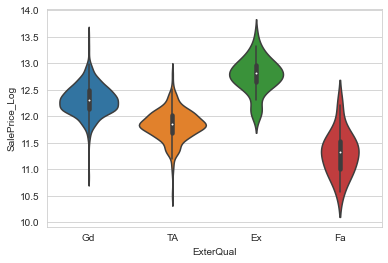

ExterQual
Ex    12.764044
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64


In [12]:
# adding the column 'SalePrice_Log' at last for computing mean of each category
df_train_cat['SalePrice_Log'] = SalePrice_Log

# make violinplots for some demo features (e.g., Top-3)
catg_strong_demo = [ 'ExterQual', 'BsmtQual','Foundation']
# catg_strong_demo = ['ExterQual']

for catg in catg_strong_demo :
#     sns.catplot(x=catg, y='SalePrice_Log', data=df_train_cat, kind='boxen')
    sns.violinplot(x=catg, y='SalePrice_Log', data=df_train_cat)
    plt.show()
    
for catg in catg_strong_demo :
    g = df_train_cat.groupby(catg)['SalePrice_Log'].mean()
    print(g) # Series is dict-like, e.g., g['Ex'] = 12.633614  
    
# drop added 'SalePrice_Log'
df_train_cat.drop('SalePrice_Log', inplace= True, axis = 1)
    

Convert all 43 Categorical columns to numerical.  

In [13]:
# make a hard copy to keep the original unchanged
df_test_cat2num = df_test_cat.copy()
df_train_cat2num = df_train_cat.copy()
# adding the column 'SalePrice_Log' (need it for converting)
df_train_cat2num['SalePrice_Log'] = SalePrice_Log
# update itself:
Categorical2Numerical(df_train_cat2num, df_test_cat2num)

df_train_cat2num.drop('SalePrice_Log',axis=1,inplace=True)

**Handle missing values in the test set**: After converting categorical columns to numerical, there might be NaN in the test set. It is due to that there is 'none' in some columns of test data, which does not exist in the corresponding column of train data. Thus, it cannot find a corresponding value when mapping values from the train data. I will fix these NaN with mean of the saleprice.

In [14]:
N_null_train = df_train_cat2num.isnull().sum().sum()
N_null_test = df_test_cat2num.isnull().sum().sum()
print('Missing values in train data:', N_null_train)
print('Missing values in test data:', N_null_test)

Missing values in train data: 0
Missing values in test data: 12


In [15]:
# where is NaN
nan_values = df_test_cat2num.isna()
nan_columns = nan_values.any()
columns_with_nan = df_test_cat2num.columns[nan_columns].tolist()
print(columns_with_nan)

# replace 'NaN' with 'SalePrice_Log_mean' in these columns
SalePrice_Log_mean = np.mean(SalePrice_Log)
for col in columns_with_nan:
    df_test_cat2num[col].fillna(SalePrice_Log_mean, inplace=True)

N_null_train = df_train_cat2num.isnull().sum().sum()
N_null_test = df_test_cat2num.isnull().sum().sum()
print('Missing values in converted train data:', N_null_train)
print('Missing values in converted test data:', N_null_test)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
Missing values in converted train data: 0
Missing values in converted test data: 0


In [16]:
# check converted Categorical columns
df_train_cat2num.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,12.085885,12.025522,12.037675,11.936094,12.022694,12.024183,12.001900,12.020565,12.163641,12.042916,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034
1,12.085885,12.025522,12.037675,11.936094,12.022694,12.024183,12.034741,12.020565,12.344176,11.818334,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034
2,12.085885,12.025522,12.037675,12.163465,12.022694,12.024183,12.001900,12.020565,12.163641,12.042916,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034
3,12.085885,12.025522,12.037675,12.163465,12.022694,12.024183,12.027446,12.020565,12.206659,12.042916,...,11.765643,11.818974,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,11.788774
4,12.085885,12.025522,12.037675,12.163465,12.022694,12.024183,12.034741,12.020565,12.676000,12.042916,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034


In [17]:
# compare with original Categorical columns
df_train_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


#### Option B: one-hot encoding category

Alternatively, ‘one-hot encode’ can be used to convert categorical variables into numeric columns (which is required by most Machine Learning algorithms). This means that all (not ordinal) factor values are getting separated columns with 1s and 0s (1 means Yes/Present).

In [18]:
# first combine train and test sets, to ensure they have the same columns
df_cat_traintest = pd.concat((df_train_cat, df_test_cat), 
                             sort=False).reset_index(drop=True)
print('train+test:',df_cat_traintest.shape)

df_cat_traintest_1hot =pd.get_dummies(df_cat_traintest)
print('train+test (1hot):',df_cat_traintest_1hot.shape)

df_cat_train_1hot = df_cat_traintest_1hot.iloc[:df_train_cat.shape[0]]# first n
df_cat_test_1hot  = df_cat_traintest_1hot.iloc[-df_test_cat.shape[0]:]# last m
df_cat_test_1hot.index = df_test_cat.index

print('train_1hot:',df_cat_train_1hot.shape)
print('test_1hot:',df_cat_test_1hot.shape)

train+test: (2919, 43)
train+test (1hot): (2919, 274)
train_1hot: (1460, 274)
test_1hot: (1459, 274)


In [19]:
df_cat_train_1hot.head()
# df_cat_test_1hot.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0


### 2.4 Merging numerical and categorical data

Merging with Option A (saleprice as a function of category), keeping the same column numbers.

In [20]:
x_train_A =df_train_num.merge(df_train_cat2num,left_index=True,right_index=True).reset_index(drop=True)
x_test_A =df_test_num.merge(df_test_cat2num,left_index=True,right_index=True).reset_index(drop=True)

print('train',x_train_A.shape)
print('test',x_test_A.shape)

train (1460, 79)
test (1459, 79)


Merging with Option B (one-hot). The column numbers increased.

In [21]:
x_train_B =df_train_num.merge(df_cat_train_1hot,left_index=True,right_index=True).reset_index(drop=True)
x_test_B =df_test_num.merge(df_cat_test_1hot,left_index=True,right_index=True).reset_index(drop=True)

print('train',x_train_B.shape)
print('test',x_test_B.shape)

train (1460, 310)
test (1459, 310)


In [22]:
x_train_A.head()
# x_test_B.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,7,5,2003,2003,0,150,856,854,0,1,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034
1,6,8,1976,1976,0,284,1262,0,0,0,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034
2,7,5,2001,2002,0,434,920,866,0,1,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034
3,7,5,1915,1970,0,540,756,756,0,1,...,11.765643,11.818974,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,11.788774
4,8,5,2000,2000,0,490,1145,1053,0,1,...,12.160778,12.172672,12.068539,12.070483,12.059895,12.022115,12.058599,12.030112,11.991061,12.005034


### 2.5 Standardization
Standardization of datasets is a common requirement for many machine learning estimators. It takes mean removal (to 0) and variance scaling to 1. Note that both the train and test sets were standardized at the same time, so that the same linear transformation was performed.

In [23]:
x_train_A, x_test_A = standardization_train_test(x_train_A, x_test_A)

print('train after standardization:',x_train_A.shape)
print('test after standardization:',x_test_A.shape)

train after standardization: (1460, 79)
test after standardization: (1459, 79)


In [24]:
x_train_A, x_test_A = standardization_train_test(x_train_A, x_test_A)

print('train after standardization:',x_train_A.shape)
print('test after standardization:',x_test_A.shape)

train after standardization: (1460, 79)
test after standardization: (1459, 79)


In [25]:
x_train_A.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.646183,-0.507284,1.046258,0.896833,-0.293136,-0.934857,-0.444323,1.207379,-0.101197,1.087017,...,0.588914,0.605970,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-0.127504
1,-0.063185,2.188279,0.154764,-0.395604,-0.293136,-0.629891,0.477115,-0.785025,-0.101197,-0.819685,...,0.588914,0.605970,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-0.127504
2,0.646183,-0.507284,0.980221,0.848965,-0.293136,-0.288511,-0.299072,1.235375,-0.101197,1.087017,...,0.588914,0.605970,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-0.127504
3,0.646183,-0.507284,-1.859351,-0.682812,-0.293136,-0.047269,-0.671279,0.978742,-0.101197,1.087017,...,-1.124627,-0.826387,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-1.640524
4,1.355551,-0.507284,0.947203,0.753229,-0.293136,-0.161063,0.211578,1.671651,-0.101197,1.087017,...,0.588914,0.605970,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-0.127504


In [26]:
x_test_A.head()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,-0.772552,0.391237,-0.340510,-1.113625,0.558191,-0.661753,-0.385315,-0.785025,-0.101197,-0.819685,...,0.588914,-0.826387,0.313678,0.305168,0.3192,-0.047017,-2.094502,0.156149,-0.231628,-0.127504
1,-0.063185,0.391237,-0.439565,-1.257229,-0.293136,-0.352236,0.629176,-0.785025,-0.101197,-0.819685,...,0.588914,-0.826387,0.313678,0.305168,0.3192,-0.047017,0.425302,0.452596,-0.231628,-0.127504
2,-0.772552,-0.507284,0.848148,0.657493,-0.293136,-0.964444,-0.280915,0.850426,-0.101197,-0.819685,...,0.588914,1.205880,0.313678,0.305168,0.3192,-0.047017,-2.094502,0.156149,-0.231628,-0.127504
3,-0.063185,0.391237,0.881166,0.657493,-0.293136,-0.538857,-0.285455,0.796766,-0.101197,-0.819685,...,0.588914,1.205880,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-0.127504
4,1.355551,-0.507284,0.683057,0.370284,-0.293136,1.038319,0.517967,-0.785025,-0.101197,-0.819685,...,0.588914,0.605970,0.313678,0.305168,0.3192,-0.047017,0.425302,0.156149,-0.231628,-0.127504


### 2.6 Save preprocessed data for further analysis

In [27]:
# add back the target (last column) to both data sets
x_train_A['SalePrice_Log'] = SalePrice_Log
x_train_B['SalePrice_Log'] = SalePrice_Log

In [28]:
# choose the path for saving 
save_dir = os.path.join(os.getcwd(), 'data')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
# save for Option A:    
x_train_A.to_csv(os.path.join(save_dir,'train_3A.csv'), index = False)
x_test_A.to_csv(os.path.join(save_dir,'test_3A.csv'), index = False)
# save for Option B:
x_train_B.to_csv(os.path.join(save_dir,'train_3B.csv'), index = False)
x_test_B.to_csv(os.path.join(save_dir,'test_3B.csv'), index = False)

End of this section.

## Reference

[House Prices: EDA to ML (Beginner)](https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner)

[House prices: Lasso, XGBoost, and a detailed EDA](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda)

[Random Forest, XGB, Ridge, Lasso : All in one](https://www.kaggle.com/janvichokshi/random-forest-xgb-ridge-lasso-all-in-one#2.-EDA-on-Categorical-Features)